# IRON HACKATHON 


- In this challenge, we received two datasets, one called "train" and other called "test"
  
- These datasets contained multiple information about health exams, patience info, etc. that were related to the Hepatitis disease
  
- The challenge was to build a model to predict if the patient will live or die, based on the "train" dataset and apply it to the test dataset (the train one had the information if the patient would live or die in order to train the model, while the test dataframe, naturally, did not have that information)

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
pd.set_option('display.max_columns', None)


## Checking the dataset that will be used to build the ML model and cleaning it 

In [2]:
# importing the datasets and checking the content

train = pd.read_csv('~/Desktop/data_analytics/Week_7/Day_5/Morning/train.csv')
test = pd.read_csv('~/Desktop/data_analytics/Week_7/Day_5/Morning/test_no_class.csv')

train.head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,48,meale,1,2,1,1,2,2,1,2,1,1,1,4.80,123,157,2.7,31,2,DIE
1,51,Male,2,2,1,2,2,2,1,1,1,2,1,1.00,?,20,3.0,63,2,LIVE
2,40,m,1,2,1,2,2,2,1,2,2,2,2,0.60,62,166,4.0,63,1,LIVE
3,25,m,2,2,1,2,2,1,1,1,1,1,1,1.30,181,181,4.5,57,2,LIVE
4,34,M,1,2,1,2,2,1,1,2,1,2,2,1.00,72,46,4.4,57,1,LIVE


In [3]:
# using a function to check if there are NaN's present in the df 

def nan_values(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function creates a pd.DataFrame which shows the percentage of NaN or null values for all the columns in the provided pd.DataFrame.
    '''
    missing_values_df = pd.DataFrame(round(df.isna().sum()/len(df),4)*100) 
    missing_values_df = missing_values_df.reset_index() 
    missing_values_df.columns = ['column_name', 'percentage_of_missing_values'] 
    return missing_values_df

In [4]:
nan_values(train)

,column_name,percentage_of_missing_values
0,AGE,0.0
1,SEX,0.0
2,STEROID,0.0
3,ANTIVIRALS,0.0
4,FATIGUE,0.0
5,MALAISE,0.0
6,ANOREXIA,0.0
7,LIVER BIG,0.0
8,LIVER FIRM,0.0
9,SPLEEN PALPABLE,0.0


In [5]:
# first step, checking the value_counts for the categorical columns 

columns_to_check = train.select_dtypes(object)

for column in columns_to_check:
    print(f"{train[column].value_counts()}")

SEX
m         20
meale     18
Male      15
M         13
maled     13
male      13
F          4
Feamle     4
female     2
Name: count, dtype: int64
STEROID
2    51
1    50
?     1
Name: count, dtype: int64
LIVER BIG
2    77
1    19
?     6
Name: count, dtype: int64
LIVER FIRM
2    55
1    40
?     7
Name: count, dtype: int64
SPLEEN PALPABLE
2    75
1    24
?     3
Name: count, dtype: int64
SPIDERS
2    65
1    34
?     3
Name: count, dtype: int64
ASCITES
2    86
1    13
?     3
Name: count, dtype: int64
VARICES
2    86
1    13
?     3
Name: count, dtype: int64
BILIRUBIN
1.00    21
0.70    12
0.90    12
0.60     8
0.80     7
1.50     6
1.30     6
4.60     3
?        3
3.20     2
2.80     2
1.60     2
2.00     2
1.20     2
3.00     1
3.90     1
1.90     1
1.10     1
0.50     1
1.70     1
4.80     1
2.90     1
7.60     1
0.30     1
2.40     1
8.00     1
2.50     1
0.40     1
Name: count, dtype: int64
ALK PHOSPHATE
?      18
85     14
62      3
78      3
155     2
81      2
76      2
95    

#### Above it is possible to see that: 
1. we have numerical columns being considered as numerical
2. most of the columns have a value "?" 

In [6]:
# function to clean the gender/sex column 

def clean_gender_column(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function will take a Pandas DataFrame as an input and it will replace the values in
    the "gender" column ins such a way that any gender which is not Male or Female with be 
    replaced by "U" otherwise the genders will be either "F" or "M"

    Inputs:
    df: Pandas DataFrame

    Outputs:
    A pandas DataFrame with the values in the "gender" column cleaned.
    '''

    df2 = df.copy()

    if "SEX" not in df2.columns:
        return df2
    else:
        df2['SEX'] = list(map(lambda x: x[0].upper() if x[0].upper() in ['M', 'F'] else "U", df2['SEX']))
        return df2

In [7]:
train = clean_gender_column(train) # applying function

In [8]:
train['SEX'].value_counts() # confirming it works 

SEX
M    92
F    10
Name: count, dtype: int64

In [9]:
# replacing the '?' with 0 - they are categorical nominal columns and have binary answer "yes"/"no" due to context, 
# let's change it to 0 to represent "other"

columns = ['STEROID', 'LIVER BIG', 'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES']

for column in columns:
    train[column] = train[column].replace('?', 0)

In [10]:
train['STEROID'].value_counts() # confirming it works 

STEROID
2    51
1    50
0     1
Name: count, dtype: int64

In [11]:
# checking the value_counts for the numerical columns 

columns_to_check = train.select_dtypes(np.number)

for column in columns_to_check:
    print(f"{train[column].value_counts()}")

AGE
50    6
34    6
51    6
30    5
44    5
36    4
54    4
23    4
38    4
39    4
28    3
27    3
37    3
45    3
56    3
31    3
52    3
40    3
42    3
47    2
48    2
49    2
61    2
69    1
24    1
67    1
58    1
7     1
60    1
43    1
25    1
62    1
35    1
20    1
46    1
59    1
22    1
41    1
33    1
53    1
65    1
32    1
Name: count, dtype: int64
ANTIVIRALS
2    87
1    15
Name: count, dtype: int64
FATIGUE
1    64
2    38
Name: count, dtype: int64
MALAISE
2    65
1    37
Name: count, dtype: int64
ANOREXIA
2    84
1    18
Name: count, dtype: int64
HISTOLOGY
2    51
1    51
Name: count, dtype: int64


In [12]:
# Let's take care of the wrong data types

train.dtypes 

AGE                 int64
SEX                object
STEROID            object
ANTIVIRALS          int64
FATIGUE             int64
MALAISE             int64
ANOREXIA            int64
LIVER BIG          object
LIVER FIRM         object
SPLEEN PALPABLE    object
SPIDERS            object
ASCITES            object
VARICES            object
BILIRUBIN          object
ALK PHOSPHATE      object
SGOT               object
ALBUMIN            object
PROTIME            object
HISTOLOGY           int64
Class              object
dtype: object

In [13]:
# changing the '?' values to NaN's and transforming these columns to numerical (they were labeled as categorical)

column_num = ['BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']
for column in column_num:
    train[column] = train[column].replace('?', np.nan)
    train[column] = pd.to_numeric(train[column], errors = 'coerce')

In [14]:
# transforming these columns to categorical (they were labeled as numerical)

cat_col = ['ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'HISTOLOGY']
for column in cat_col:
    train[column] = train[column].astype(object)

In [15]:
train.dtypes # confirming it works

AGE                  int64
SEX                 object
STEROID             object
ANTIVIRALS          object
FATIGUE             object
MALAISE             object
ANOREXIA            object
LIVER BIG           object
LIVER FIRM          object
SPLEEN PALPABLE     object
SPIDERS             object
ASCITES             object
VARICES             object
BILIRUBIN          float64
ALK PHOSPHATE      float64
SGOT               float64
ALBUMIN            float64
PROTIME            float64
HISTOLOGY           object
Class               object
dtype: object

In [16]:
train.head() # final result - still have the NaN's in the numerical columns 

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,48,M,1,2,1,1,2,2,1,2,1,1,1,4.8,123.0,157.0,2.7,31.0,2,DIE
1,51,M,2,2,1,2,2,2,1,1,1,2,1,1.0,NaN,20.0,3.0,63.0,2,LIVE
2,40,M,1,2,1,2,2,2,1,2,2,2,2,0.6,62.0,166.0,4.0,63.0,1,LIVE
3,25,M,2,2,1,2,2,1,1,1,1,1,1,1.3,181.0,181.0,4.5,57.0,2,LIVE
4,34,M,1,2,1,2,2,1,1,2,1,2,2,1.0,72.0,46.0,4.4,57.0,1,LIVE


## Further processing the data and also doing the train/test split 

In [17]:
# dropping the column we want to predict from the df 

y = train['Class']
X = train.drop(['Class'], axis = 1) 

# train/test spliting 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# spliting our X_train and X_test sets into numerical and categorical columns and isolating the 'SEX' column 

X_train_num = X_train.select_dtypes(np.number)
X_test_num  = X_test.select_dtypes(np.number)

X_train_cat = X_train.select_dtypes(object) 
sex_column_train = X_train_cat[['SEX']]
X_train_cat = X_train_cat.drop(columns=['SEX'])

X_test_cat  = X_test.select_dtypes(object)
sex_column_test = X_test_cat[['SEX']]
X_test_cat = X_test_cat.drop(columns=['SEX'])

# applying a scaler on our numerical X_train/X_test sets 

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train_num)
scaled_test = scaler.transform(X_test_num)

scaled_train_df = pd.DataFrame(scaled_train, columns = X_train_num.columns, index = X_train_num.index)
scaled_test_df = pd.DataFrame(scaled_test, columns = X_test_num.columns, index = X_test_num.index)

# one hot encoding the 'SEX' column 

encoder = OneHotEncoder(drop = 'first', sparse = False)

sex_encoded_train = encoder.fit_transform(sex_column_train)
sex_encoded_test = encoder.transform(sex_column_test)

sex_encoded_train_df = pd.DataFrame(sex_encoded_train, columns = encoder.get_feature_names_out(['SEX']), index=sex_column_train.index)
sex_encoded_test_df = pd.DataFrame(sex_encoded_test, columns = encoder.get_feature_names_out(['SEX']), index=sex_column_test.index)

# now we are gonna take care of the NaN's in the numerical columns using the KNN imputer - for the original hackathon final results, 
# the n_neighbours used was 5, but I will change it to 3 now to check the results 

imputer = KNNImputer(n_neighbors = 3, weights = 'uniform', metric = 'nan_euclidean')
train_nans_imputed = pd.DataFrame(imputer.fit_transform(scaled_train_df), columns = scaled_train_df.columns, index = scaled_train_df.index)
test_nans_imputed = pd.DataFrame(imputer.transform(scaled_test_df), columns = scaled_test_df.columns, index = scaled_test_df.index)

# concatenating the numerical imputed by KNN, the categoricals and the 'SEX' column the was one encoded and then  we have our final datasets
# that will be used to train the model

X_train_final = pd.concat([train_nans_imputed, X_train_cat, sex_encoded_train_df], axis = 1)
X_test_final  = pd.concat([test_nans_imputed, X_test_cat, sex_encoded_test_df], axis = 1)

/Users/vschuckar/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
X_train_final

,AGE,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,HISTOLOGY,SEX_M
62,0.666667,0.095890,0.601770,0.057034,0.192308,0.310000,2,2,1,1,2,2,1,2,1,1,1,2,1.0
3,0.300000,0.136986,0.668142,0.631179,0.923077,0.570000,2,2,1,2,2,1,1,1,1,1,1,2,1.0
79,0.716667,0.095890,0.482301,0.250951,0.692308,0.620000,2,2,2,2,2,2,2,2,2,2,2,2,1.0
45,0.250000,0.082192,0.079646,0.019011,0.807692,0.640000,2,1,1,2,2,2,2,2,2,2,2,1,0.0
48,0.633333,0.136986,0.243363,0.110266,0.807692,0.850000,2,1,2,2,2,2,2,2,2,2,2,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.516667,0.013699,0.942478,0.129278,0.653846,0.900000,1,2,2,2,2,2,1,2,2,2,2,2,1.0
67,0.616667,0.082192,0.464602,0.152091,0.641026,0.410000,1,2,1,1,2,2,2,1,2,2,1,2,1.0
64,0.600000,0.123288,0.309735,0.015209,0.384615,0.420000,2,2,1,2,2,2,2,1,1,1,2,2,1.0
47,0.733333,0.082192,0.203540,0.973384,0.884615,0.583333,2,2,1,1,1,0,0,0,0,0,0,1,1.0


## ML modelling 

In [19]:
# checking the column we want to predict for class imbalance

train['Class'].value_counts()

Class
LIVE    81
DIE     21
Name: count, dtype: int64

In [20]:
# applyng the SMOTE technique to solve the class imbalance 

sm = SMOTE(random_state = 100) 
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_final, y_train)

print(y_train_SMOTE.value_counts())

Class
DIE     64
LIVE    64
Name: count, dtype: int64


### ML - Random Forest 

The Accuracy for the Random Forest in the TRAIN set is 1.00
The Accuracy for the Random Forest in the TEST  set is 0.81


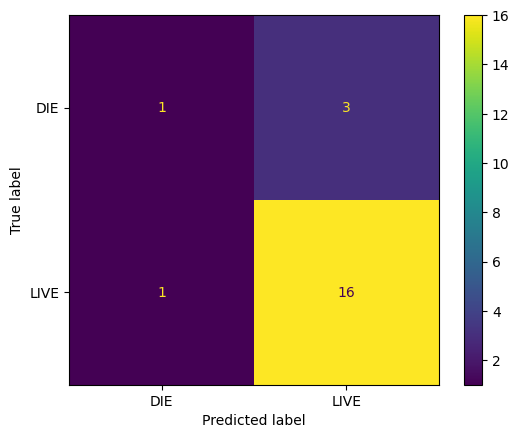

In [21]:
# modeling our data with Random Forest classifier - also printing the accuracy since it is the metric this classifier 
# tries to always increase (thus making it "better")

clf = RandomForestClassifier()

clf.fit(X_train_SMOTE, y_train_SMOTE)

print("The Accuracy for the Random Forest in the TRAIN set is {:.2f}".format(clf.score(X_train_SMOTE, y_train_SMOTE)))
print("The Accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test_final, y_test)))

y_test_pred = clf.predict(X_test_final)

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm_test, display_labels = clf.classes_);
disp.plot()

In [22]:
# now we will use the make_scorer and the grid_search to improve our parameters of the model to increase the KAPPA and not the accuracy 

scorer = make_scorer(cohen_kappa_score)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']}

grid_search = GridSearchCV(clf, param_grid, scoring = scorer, cv = 10, return_train_score = True, n_jobs = -1, verbose = 20)
grid_search.fit(X_train_SMOTE, y_train_SMOTE)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 6/10; 1/108] START max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 6/10; 1/108] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 8/10; 2/108] START max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 8/10; 2/108] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 5/10; 3/108] START max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 5/10; 3/108] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=1.000, test=0.698) total time=   0.2s
[CV 5/10; 4/108] START max_depth=None, max_features=sqrt, min_samples_leaf=1, min_sample

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring=make_scorer(cohen_kappa_score),
             verbose=20)

In [23]:
# getting the best kappa and the best parameters

best_params = grid_search.best_params_

best_kappa_score = grid_search.best_score_


In [24]:
# storing the best parameters that enhance the kappa value

best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_max_features = best_params['max_features']

In [25]:
# checking out what were the parameters selected and the final kappa

print(best_n_estimators)
print(best_max_depth)
print(best_min_samples_split)
print(best_min_samples_leaf)
print(best_max_features)
print(best_kappa_score)

50
20
2
1
sqrt
0.9235165559639379


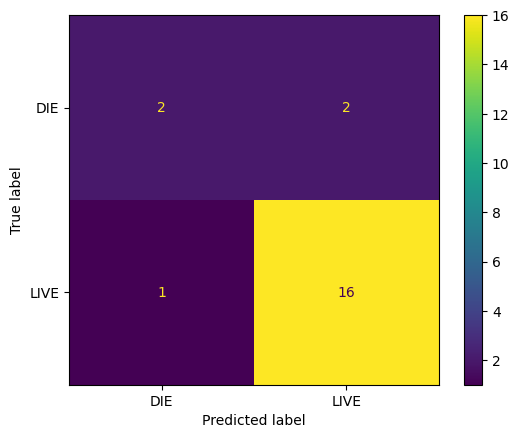

In [26]:
# trying another ML model type 

lr = LogisticRegression()
lr.fit(X_train_SMOTE, y_train_SMOTE)


y_test_pred = lr.predict(X_test_final)

cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm_test, display_labels = lr.classes_);
disp.plot()

#### Now that the models were build, we will deal with the csv file that will be used to apply our model and predict "Class" in this case, if a person will live or die due to hepatitis 

First step will be the data cleaning of this dataframe in the same way we did with for the "train" dataframe 

In [27]:
# checking the test df 

test.head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,39,Male,2,2,1,2,2,2,1,2,2,2,2,0.70,?,48,4.4,?,1
1,41,Feamle,2,1,1,1,1,2,2,2,2,2,2,0.70,81,53,5.0,74,1
2,28,maled,1,2,1,1,1,2,1,2,2,2,2,1.60,44,123,4.0,46,1
3,36,maled,1,2,1,1,1,2,1,2,2,2,2,1.00,?,45,4.0,57,1
4,32,M,2,2,2,2,2,2,2,2,2,2,2,0.70,102,64,4.0,90,1


In [28]:
# applying the function to check for NaN's

nan_values(test)

,column_name,percentage_of_missing_values
0,AGE,0.0
1,SEX,0.0
2,STEROID,0.0
3,ANTIVIRALS,0.0
4,FATIGUE,0.0
5,MALAISE,0.0
6,ANOREXIA,0.0
7,LIVER BIG,0.0
8,LIVER FIRM,0.0
9,SPLEEN PALPABLE,0.0


In [29]:
# applying the function to deal with the multiple values for the 'SEX' column - leaving only F for female and M for male as we did for the train df

test = clean_gender_column(test)

In [30]:
test['SEX'].value_counts() # confirming it works

SEX
M    47
F     6
Name: count, dtype: int64

In [31]:
# replacing the '?' values to 0 in the categorical columns 

columns = ['FATIGUE', 'MALAISE','ANOREXIA', 'STEROID', 'LIVER BIG', 'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES']
for column in columns:
    test[column] = test[column].replace('?', 0)

In [32]:
# replacing the '?' values to NaN's for the numerical columns

column_num = ['BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']
for column in column_num:
    test[column] = test[column].replace('?', np.nan)
    test[column] = pd.to_numeric(test[column], errors = 'coerce')

In [33]:
# changing the columns which had a wrong type  

cat_col = ['STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'HISTOLOGY']
for column in cat_col:
    test[column] = test[column].astype('object')

In [34]:
# confirming what we have for the values of the categorical columns 

columns_to_check = test.select_dtypes(object)

for column in columns_to_check:
    print(f"{test[column].value_counts()}")

SEX
M    47
F     6
Name: count, dtype: int64
STEROID
2    27
1    26
Name: count, dtype: int64
ANTIVIRALS
2    44
1     9
Name: count, dtype: int64
FATIGUE
1    36
2    16
0     1
Name: count, dtype: int64
MALAISE
2    28
1    24
0     1
Name: count, dtype: int64
ANOREXIA
2    38
1    14
0     1
Name: count, dtype: int64
LIVER BIG
2    43
1     6
0     4
Name: count, dtype: int64
LIVER FIRM
2    29
1    20
0     4
Name: count, dtype: int64
SPLEEN PALPABLE
2    45
1     6
0     2
Name: count, dtype: int64
SPIDERS
2    34
1    17
0     2
Name: count, dtype: int64
ASCITES
2    44
1     7
0     2
Name: count, dtype: int64
VARICES
2    46
1     5
0     2
Name: count, dtype: int64
HISTOLOGY
1    34
2    19
Name: count, dtype: int64


In [35]:
# confirming what we have for the values of the numerical columns 

columns_to_check = test.select_dtypes(np.number)

for column in columns_to_check:
    print(f"{test[column].value_counts(dropna=False)}")

AGE
38    4
36    3
32    3
30    3
39    2
34    2
33    2
37    2
42    2
41    2
45    2
57    2
28    2
20    2
47    2
25    2
26    1
35    1
27    1
54    1
70    1
61    1
62    1
66    1
64    1
78    1
58    1
24    1
22    1
49    1
72    1
31    1
Name: count, dtype: int64
BILIRUBIN
0.7    11
1.0     8
1.2     6
2.3     3
NaN     3
0.8     3
2.0     2
1.7     2
1.4     2
0.6     2
2.2     1
0.4     1
1.6     1
4.1     1
1.5     1
4.6     1
0.5     1
3.5     1
1.8     1
4.2     1
0.9     1
Name: count, dtype: int64
ALK PHOSPHATE
NaN      11
85.0      4
81.0      2
102.0     2
82.0      2
75.0      2
72.0      1
135.0     1
215.0     1
109.0     1
191.0     1
80.0      1
160.0     1
280.0     1
26.0      1
62.0      1
133.0     1
65.0      1
58.0      1
118.0     1
175.0     1
63.0      1
100.0     1
125.0     1
67.0      1
115.0     1
59.0      1
147.0     1
96.0      1
295.0     1
57.0      1
150.0     1
84.0      1
45.0      1
44.0      1
70.0      1
Name: count, dtype: in

In [36]:
test.dtypes # confirming that the type matches the column content now 

AGE                  int64
SEX                 object
STEROID             object
ANTIVIRALS          object
FATIGUE             object
MALAISE             object
ANOREXIA            object
LIVER BIG           object
LIVER FIRM          object
SPLEEN PALPABLE     object
SPIDERS             object
ASCITES             object
VARICES             object
BILIRUBIN          float64
ALK PHOSPHATE      float64
SGOT               float64
ALBUMIN            float64
PROTIME            float64
HISTOLOGY           object
dtype: object

Now the we cleaned, prepared and build a model on the train dataset and cleaned and prepared the test dataset, we can apply the models created to the test dataset 

#### Applying ML models to the test dataset

In [37]:
# separating the numerical and categorical columns of the dataset, and separating further the column 'SEX' from the categorical 

new_test_num = test.select_dtypes(np.number)
new_test_cat  = test.select_dtypes(object)
sex_column = new_test_cat[['SEX']]
new_test_cat = new_test_cat.drop(columns=['SEX'])

# using the onehotencoder for the 'SEX' column 

sex_encoded = encoder.transform(sex_column)
sex_encoded_df = pd.DataFrame(sex_encoded, columns = encoder.get_feature_names_out(['SEX']), index=sex_column.index)

# scaling the numerical columns 

new_test_scaled = scaler.transform(new_test_num)
new_test_scaled_df = pd.DataFrame(new_test_scaled, columns = new_test_num.columns, index = new_test_num.index)

# imputing the numerical columns with the KNN imputer in order to deal with the NaN's 

new_test_imputed = pd.DataFrame(imputer.transform(new_test_scaled_df), columns = new_test_scaled_df.columns, index = new_test_scaled_df.index)

# concatenating the full transformed dataset 

new_test_final = pd.concat([new_test_imputed, new_test_cat, sex_encoded_df], axis = 1)

In [38]:
new_test_final.head() # dataset is now ready for the model to be applied

,AGE,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,HISTOLOGY,SEX_M
0,0.533333,0.054795,0.234513,0.125475,0.884615,0.61,2,2,1,2,2,2,1,2,2,2,2,1,1.0
1,0.566667,0.054795,0.225664,0.144487,1.115385,0.74,2,1,1,1,1,2,2,2,2,2,2,1,0.0
2,0.350000,0.178082,0.061947,0.410646,0.730769,0.46,1,2,1,1,1,2,1,2,2,2,2,1,1.0
3,0.483333,0.095890,0.261062,0.114068,0.730769,0.57,1,2,1,1,1,2,1,2,2,2,2,1,1.0
4,0.416667,0.054795,0.318584,0.186312,0.730769,0.90,2,2,2,2,2,2,2,2,2,2,2,1,1.0


In [39]:
# applying the Random Forest with the best parameters found that increased the kappa 

new_model = RandomForestClassifier(
    n_estimators = best_n_estimators,
    max_depth = best_max_depth,
    min_samples_split = best_min_samples_split,
    min_samples_leaf = best_min_samples_leaf,
    max_features = best_max_features,
    random_state = 42  
)

new_model.fit(X_train_SMOTE, y_train_SMOTE)

predictions = new_model.predict(new_test_final)

In [40]:
# trying out new parameters!

new_model_one = RandomForestClassifier(
    n_estimators = 70,
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    random_state = 2  
)

new_model_one.fit(X_train_SMOTE, y_train_SMOTE)

predictions_one = new_model_one.predict(new_test_final)

In [41]:
result_df = pd.DataFrame({'Class': predictions}) # saving the predictions as a dataframe

In [42]:
result_df_new = pd.DataFrame({'Class': predictions_one}) # saving the predictions as a dataframe

In [43]:
# applying the other model - Logistic Regression 

new_test_pred = lr.predict(new_test_final)
result_lr_df = pd.DataFrame({'Class': new_test_pred})

Saving the predictions for all models to csv files

In [44]:
result_df.to_csv('group_8.csv')

In [45]:
result_df_new.to_csv('group_8_2.csv')

In [46]:
result_lr_df.to_csv('group_8_3.csv')

As soon as those csv's were sent to the professor, he would analyse it and return the final kappa score of our prediction to us. 
The winner would be who had the highest final kappa and in case of the same kappa, less results submissions! 

The file with the real test results is the test.csv, the professor sent it to us afterwards in case we want to check it out. 

The final ranking was: 

Group//	Best_Kappa// Submissions

4	      0.541	         2

8	      0.541	         3

5	      0.541	         4

6	      0.501	         4

2	      0.462	         4

3	      0.427	         5

7	      0.393          5

1	      0.339  	     2

We were **group number 8**, winning the second place, with the same kappa as the first place but with one more submission! 